In [1]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def lags(df, lag_feats, lags=(1,2,3)):
    df = df.sort_values("date").reset_index(drop=True)
    for L in lags:
        for feat in lag_feats:
            df[f"{feat}_lag{L}"] = df[feat].shift(L)
    for L in lags:
        df[f"label_lag{L}"] = df["label"].shift(L)

    df = df.dropna().reset_index(drop=True)
    return df


def tune_and_evaluate(path):
    df = pd.read_csv(path, parse_dates=["date"])
    df = lags(df, lag_feats=[
    " Price Index for Consumer: Energy(electricity, heat, fuel) ",
    "Crude Oil Prices: Brent - Europe",
    "euro_stoxx",
    ], lags=(1,2,3))

    #chronological split
    split = int(len(df)*0.8)
    train, test = df.iloc[:split], df.iloc[split:]
    X_train = train.drop(columns=["date","label"])
    y_train = train["label"]
    X_test  = test.drop(columns=["date","label"])
    y_test  = test["label"]

    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    param_dist = {
    "n_estimators":      [100, 200, 500],
    "max_depth":         [None, 10, 20, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 5, 10],
    "max_features":      ["sqrt", 0.5, 0.8],
    "max_leaf_nodes":    [None, 20, 50, 100],
    "ccp_alpha":         [0.0, 1e-4, 1e-3, 1e-2],
    "bootstrap":         [True, False],
}

    tscv = TimeSeriesSplit(n_splits=4)
    search = RandomizedSearchCV(
        rf, param_dist,
        n_iter=50,
        cv=tscv,
        scoring="r2",
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)


    best = search.best_estimator_
    preds = best.predict(X_test)
    mse  = mean_squared_error(y_test, preds)
    rmse = mse ** 0.5
    return {
        "dataset": os.path.basename(path),
        "n_samples": len(df),
        "n_features": X_train.shape[1],
        "best_params": search.best_params_,
        "RMSE": round(rmse, 3),
        "MAE":  round(mean_absolute_error(y_test, preds), 3),
        "R2":   round(r2_score(y_test, preds), 3),
    }

results = []
for full_path in (
    "/content/10md_sentiment.csv",
    "/content/10wm_sentiment.csv"):
    results.append(tune_and_evaluate(full_path))


res_df = pd.DataFrame(results).sort_values("R2", ascending=False)
print(res_df.to_string(index=False))


           dataset  n_samples  n_features                                                                                                                                                                best_params  RMSE   MAE    R2
10md_sentiment.csv       2371          21 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 0.8, 'max_depth': 50, 'ccp_alpha': 0.001, 'bootstrap': False} 3.500 2.821 0.873
10wm_sentiment.csv        506          21 {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_features': 0.8, 'max_depth': 10, 'ccp_alpha': 0.001, 'bootstrap': False} 6.388 5.222 0.608


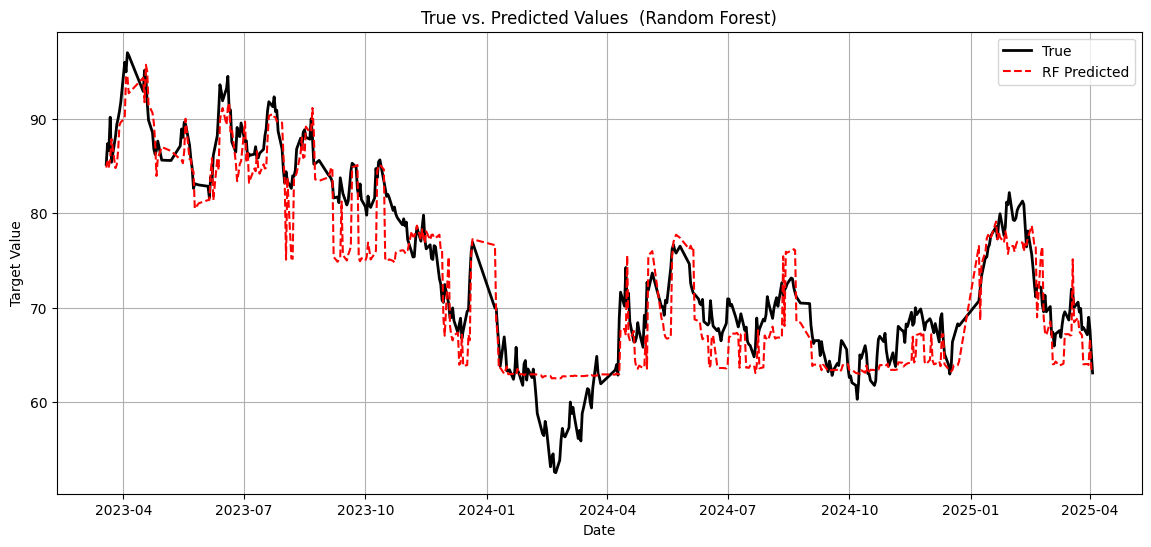

           Model  RMSE    MAE     R2
0  Random Forest   3.5  2.821  0.873


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def lags(df, lag_feats, lags=(1, 2, 3)):
    df = df.sort_values("date").reset_index(drop=True)
    for L in lags:
        for feat in lag_feats:
            df[f"{feat}_lag{L}"] = df[feat].shift(L)
    for L in lags:
        df[f"label_lag{L}"] = df["label"].shift(L)
    df = df.dropna().reset_index(drop=True)
    return df

def tune_and_evaluate(path):
    df = pd.read_csv(path, parse_dates=["date"])
    df = lags(df, lag_feats=[
        " Price Index for Consumer: Energy(electricity, heat, fuel) ",
        "Crude Oil Prices: Brent - Europe",
        "euro_stoxx",
    ], lags=(1, 2, 3))

    # Chronological split
    split = int(len(df) * 0.8)
    train, test = df.iloc[:split], df.iloc[split:]
    X_train = train.drop(columns=["date", "label"])
    y_train = train["label"]
    X_test = test.drop(columns=["date", "label"])
    y_test = test["label"]

    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    param_dist = {
        "n_estimators": [100, 200, 500],
        "max_depth": [None, 10, 20, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5, 10],
        "max_features": ["sqrt", 0.5, 0.8],
        "max_leaf_nodes": [None, 20, 50, 100],
        "ccp_alpha": [0.0, 1e-4, 1e-3, 1e-2],
        "bootstrap": [True, False],
    }
    tscv = TimeSeriesSplit(n_splits=4)
    search = RandomizedSearchCV(
        rf, param_dist, n_iter=50, cv=tscv, scoring="r2", random_state=42, n_jobs=-1
    )
    search.fit(X_train, y_train)
    best_rf = search.best_estimator_
    rf_preds = best_rf.predict(X_test)

    def get_metrics(y_true, y_pred, model_name):
        return {
            "Model": model_name,
            "RMSE": round(np.sqrt(mean_squared_error(y_true, y_pred)), 3),
            "MAE": round(mean_absolute_error(y_true, y_pred), 3),
            "R2": round(r2_score(y_true, y_pred), 3),
        }

    metrics = [
        get_metrics(y_test, rf_preds, "Random Forest"),
    ]

    plt.figure(figsize=(14, 6))
    plt.plot(test["date"], y_test, label="True", color="black", linewidth=2)
    plt.plot(test["date"], rf_preds, label="RF Predicted", linestyle="--", color="red")
    plt.title("True vs. Predicted Values  (Random Forest)")
    plt.xlabel("Date")
    plt.ylabel("Target Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    return pd.DataFrame(metrics)

results = tune_and_evaluate("/content/10md_sentiment.csv")
print(results)

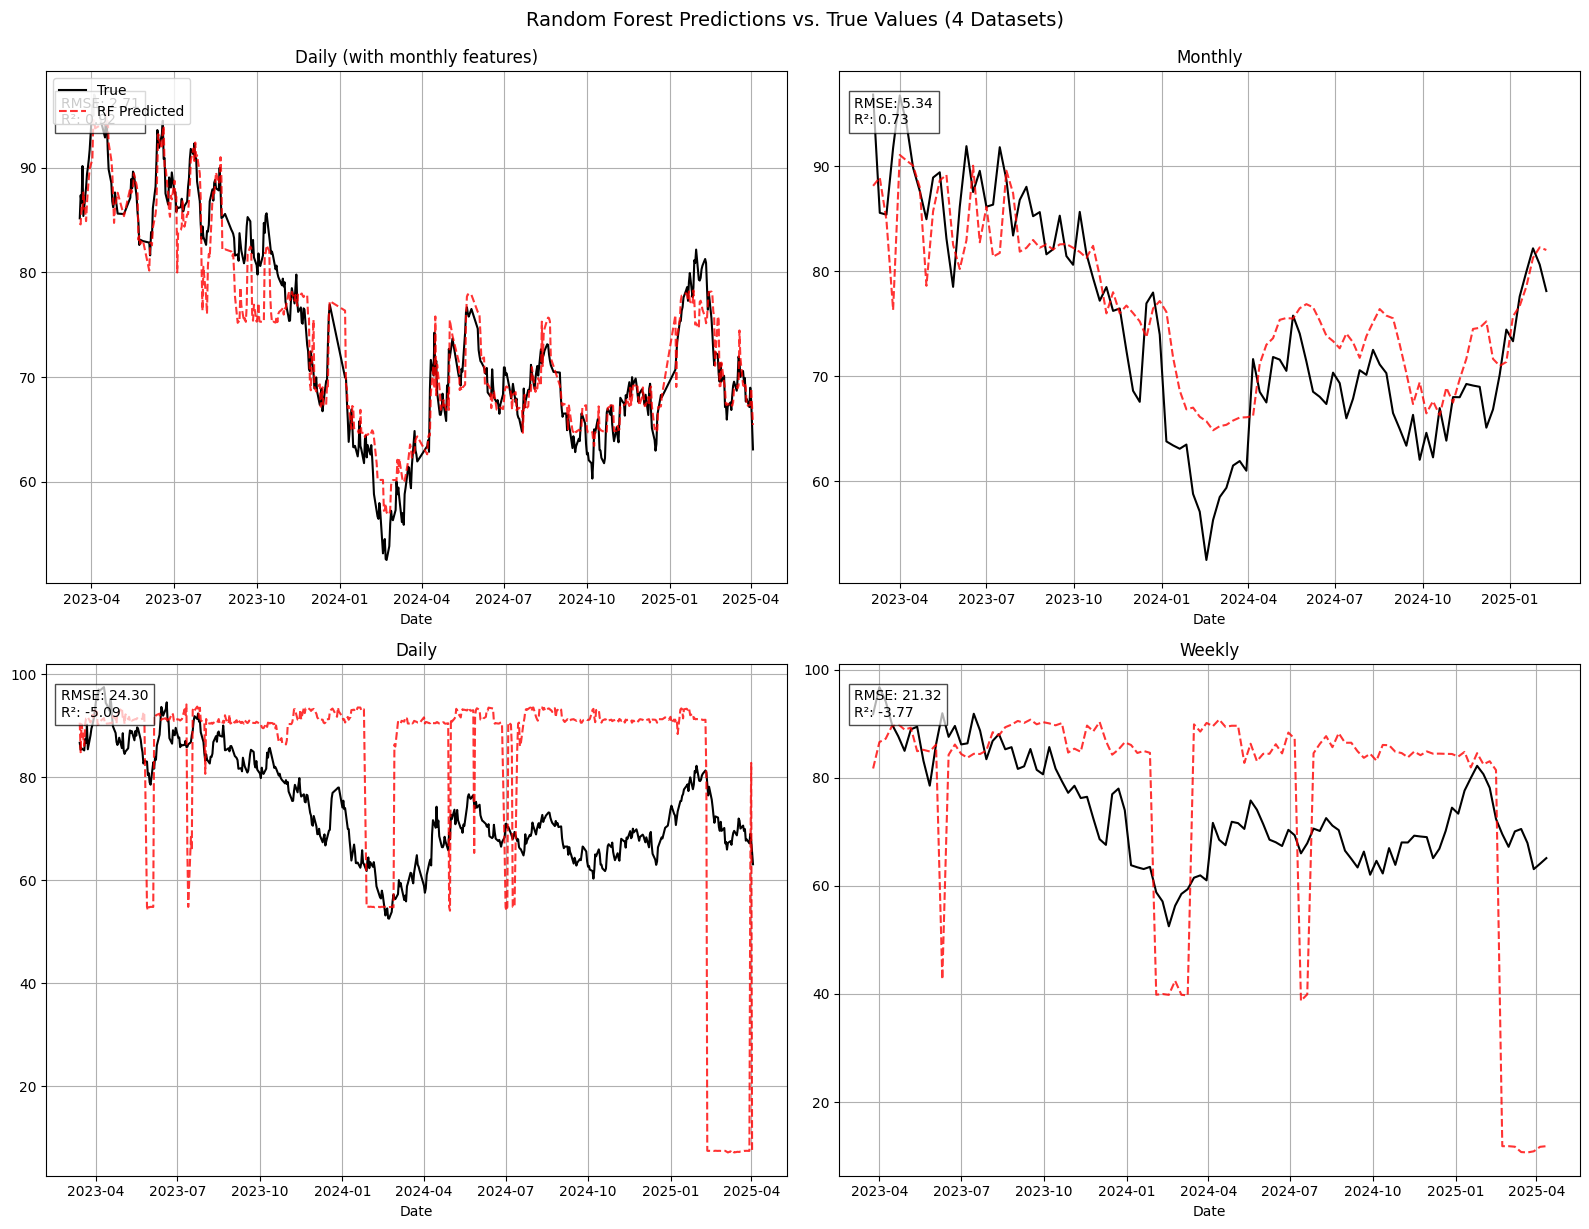


Performance Metrics:
                                RMSE     R²
Daily (with monthly features)   2.71   0.92
Monthly                         5.34   0.73
Daily                          24.30  -5.09
Weekly                         21.32  -3.77


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def lags(df, lag_feats, lags=(1, 2, 3)):
    df = df.sort_values("date").reset_index(drop=True)
    for L in lags:
        for feat in lag_feats:
            df[f"{feat}_lag{L}"] = df[feat].shift(L)
    for L in lags:
        df[f"label_lag{L}"] = df["label"].shift(L)
    df = df.dropna().reset_index(drop=True)
    return df

def evaluate_and_plot_rf(path, ax, title):
    df = pd.read_csv(path, parse_dates=["date"])

    if "10md" in path:
        df = lags(df, lag_feats=[
            " Price Index for Consumer: Energy(electricity, heat, fuel) ",
            "Crude Oil Prices: Brent - Europe",
            "euro_stoxx"
        ])
    if "10wm" in path:
        df = lags(df, lag_feats=[
            " Price Index for Consumer: Energy(electricity, heat, fuel) ",
            "Crude Oil Prices: Brent - Europe",
            "euro_stoxx"
        ])

    # Chronological split
    split = int(len(df) * 0.8)
    train, test = df.iloc[:split], df.iloc[split:]
    X_train = train.drop(columns=["date", "label"])
    y_train = train["label"]
    X_test = test.drop(columns=["date", "label"])
    y_test = test["label"]

    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        random_state=42,
    )
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)

    ax.plot(test["date"], y_test, label="True", color="black", linewidth=1.5)
    ax.plot(test["date"], preds, label="RF Predicted", linestyle="--", color="red", alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.grid(True)

    metrics = {
        "RMSE": f"{np.sqrt(mean_squared_error(y_test, preds)):.2f}",
        "R²": f"{r2_score(y_test, preds):.2f}"
    }
    textstr = "\n".join([f"{k}: {v}" for k, v in metrics.items()])
    ax.text(0.02, 0.95, textstr, transform=ax.transAxes,
            fontsize=10, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))

    return metrics

dataset_paths = [
    "/content/10md_sentiment.csv",
    "/content/10wm_sentiment.csv",
    "/content/10d_sentiment.csv",
    "/content/10w_sentiment.csv"
]
dataset_names = [
    "Daily (with monthly features)",
    "Monthly",
    "Daily",
    "Weekly"
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

all_metrics = {}
for i, (path, name) in enumerate(zip(dataset_paths, dataset_names)):
    metrics = evaluate_and_plot_rf(path, axes[i], name)
    all_metrics[name] = metrics

axes[0].legend(loc="upper left")

plt.tight_layout()
plt.suptitle("Random Forest Predictions vs. True Values (4 Datasets)", y=1.02, fontsize=14)
plt.show()
metrics_df = pd.DataFrame(all_metrics).T
print("\nPerformance Metrics:")
print(metrics_df)